# Implementación de Grid Search, Pipelines, NLP con corpus de Twitter.

### Intro
Análisis de sentimiento sobre mensajes de twitter mediante la aplicación de técnicas de NLP (Natural Language Processing) y posteriormente ML (Machine Learning). 
Dentro de lo que es el pre-procesamiento de los datos, se limpian y tokenizan para poder generar un BOW (Bag of Words) que permita alimentar los distintos modelos. Cada modelo es entrenado por separado y optimizado mediante la implementación de GridSearch.

#### Preproceso de Datos

In [2]:
import re
import numpy as np
import csv
import unicodedata
import warnings

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## Clasificadores
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')

# Filenames
file_name="./csv/union_salida_clasificada_negposneu.csv"
stop_file="custom_stopwords.txt"    # Nombre del archivo de stopwords.


# Regex para tokenizar correctamente.
regex_str = [
    r'(?:[\w_]+)',                                        # Otras palabras
    r'(?:\S)'                                             # Cualquier otra cosa
]

# Se arman objetos para regular expresions.
tokens_re   = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)

# Se carga archivos de STOPWORDS
with open(stop_file, newline='') as file:
    stopwords = file.read().splitlines()

resX = []
X = []
y = []
    
# Se abre archivo con tweets y se lo recorre    
with open(file_name, newline='') as csvfile:

    reader = csv.reader(csvfile, delimiter=',', quotechar='\"')
    header = next(reader)
    
    for row in reader:

        y.append(row[0].lower())
        
        tweet = row[1].lower()                    # Se normaliza texto, todo a minusculas.
        tweet = re.sub(r'@[a-z0-9_]+', '', tweet) # Se quitan menciones. @xxxxxxxx
        tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
        tweet = tweet.translate(str.maketrans('','', '.~¡!-_—#$%¿?:+-/°);(/",*“”‘’'))
        
        # Manejo de emoticones.
        emoticones = [
                      ['😆',' risa'],['😂','risa'],['😱',' asombro'],['🥳',' felicidad'],['💙',' amor'],['😍',' amor'],
                      ['😀',' sonreir'],['👍',' ok'],['🤔',' dudar'],['🎊',' alegria'],['🙏',' ojala'],['💪🏻',' fuerza'],
                      ['😡',' enojo'],['😛',' broma'],['😮',' asombro'],['🤮',' desagradable'],['👏🏻',' aplauso'],
                      ['😏',' canchero'],['😩',' decepcion'],['😳',' verguenza'],['😊',' contento'],['😥',' triste'],
                      ['😤',' furioso'],['🖕',' enojo'],['👏',' aplauso'],['💪',' fuerza'],['🤦‍','increible'],
                      ['🙄','duda']
                     ]
        for emoji in emoticones:
            tweet = tweet.replace(emoji[0], emoji[1])

        # Manejo de acentos.
        dict_acentos = [['á','a'],['é','e'],['í','i'],['ó','o'],['ú','u']]
        for acento in dict_acentos:
            tweet = tweet.replace(acento[0], acento[1])
            
        # Remueve letras repetidas y deja una sola.
        for letra in ['a','e','i','o','u','s','c']:
            pattern = letra + '{2,}'
            tweet = re.sub(pattern, letra, tweet)
        
        tweet = tweet.translate(str.maketrans('','', '🥝🐧🐳🖐🛫😑✈🇦🇷🇵🇾👇🙃▶💻►→⬇️😒🔫🔝🔥💀🚫😞♂❤❤❤😎👊🤞🏻'))
        tweet = re.sub(r'\d+', '', tweet)         # Se quitan numeros.
        tweet = tweet.strip()
    
        # Tokenizado
        tokens = tokens_re.findall(tweet)

        # Remocion de stopwords
        tokens = [token for token in tokens if token not in stopwords]
        
        #Para resumen
        resX.append(tokens)
        
        s = ' '
        X.append(s.join(tokens))


#### Medidas de resumen

In [6]:
print('Positivos: ', y.count('positivo'))
print('Neutros:   ', y.count('neutro'))
print('Negativos: ', y.count('negativo'))

Positivos:  124
Neutros:    121
Negativos:  256


### Busqueda de hyperparametros mediante GridSearch

In [2]:
# --- Pipelines ---
pipeline1 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', SVC())
                     ])
pipeline2 = Pipeline([#('vectorizer', CountVectorizer()),
                      #('tfidf', TfidfTransformer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', DecisionTreeClassifier())
                     ])
pipeline3 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', MLPClassifier())
                     ])
pipeline4 = Pipeline([#('vectorizer', CountVectorizer()),
                      ('tfidf', TfidfVectorizer()),
                      ('clf', MultinomialNB())
                     ])


# --- Parameters ---
param_svm = [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
               'tfidf__binary' : (True, False),
               'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
               'tfidf__smooth_idf' : (True, False),
               'tfidf__use_idf': (True, False),
               'clf__kernel': ['rbf','linear'],
               'clf__gamma': [1e-3, 1e-4, 1e-5],
               'clf__C': [1, 10, 100, 1000]
             }]
param_tree = [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__criterion': ['gini', 'entropy'],
                'clf__max_depth': [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                'clf__min_samples_leaf': [1, 5, 10, 20]
              }]    
param_red =  [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__solver': ['lbfgs'], 
                'clf__max_iter': [300], 
                'clf__alpha': 10.0 ** -np.arange(1, 7), 
                'clf__hidden_layer_sizes':np.arange(5, 10), 
                'clf__random_state': [6,8] 
              }]
param_nb  =  [{ 'tfidf__ngram_range': [(1, 1),(1, 2),(2, 2)],
                'tfidf__binary' : (True, False),
                'tfidf__norm': ['l1','l2',None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : (True, False),
                'tfidf__use_idf': (True, False),
                'clf__alpha': np.linspace(0.5, 1.5, 6),
                'clf__fit_prior': [True, False] 
              }]


# --- Scores ---
scores = ['precision', 'recall']
model = [ "SVM", "Neural Network", "Naive Bayes", "Random Forest"]
pips = [pipeline1, pipeline3, pipeline4, pipeline2]
pars = [param_svm, param_red,  param_nb, param_tree]


# --- Cros Validate ---
cvNum = 10
print("Comenzando Gridsearch!")

for i in range(len(pars)):
    print(model[i])
    for score in scores:
        
        gs_clf = GridSearchCV( pips[i], pars[i], cv=cvNum, 
                                   scoring='%s_weighted' % score, n_jobs=-1, 
                                   verbose=0, refit=False)
        gs_clf = gs_clf.fit(X, y)
        print(score, gs_clf.best_score_)
        print("Parametros: %s" % gs_clf.best_params_)

Comenzando Gridsearch!
SVM
precision 0.7284534492764374
Parametros: {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'linear', 'tfidf__binary': False, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}
recall 0.7125748502994012
Parametros: {'clf__C': 1000, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'tfidf__binary': False, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': True, 'tfidf__use_idf': False}
Neural Network
precision 0.7403521316140691
Parametros: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': 5, 'clf__max_iter': 300, 'clf__random_state': 6, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': None, 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}
recall 0.718562874251497
Parametros: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': 6, 'clf__max_iter': 300, 'clf__random_state': 8, 'clf__solver': 'lbfgs', 'tfidf__binary': False, 'tfidf__ngram_range': (1, 1), 'tfid

### GridSearch con Mejores Parametros

In [4]:
# --- Pipelines ---
pipeline1 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC()) ])
pipeline2 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier())])
pipeline3 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MLPClassifier())])
pipeline4 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# --- Parameters ---
param_svm = [{ 'tfidf__ngram_range': [(1, 2)], 'tfidf__binary': [False],
               'tfidf__norm': ['l2'],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
               'tfidf__smooth_idf' : [False], 'tfidf__use_idf': [True],
               'clf__kernel': ['linear'], 'clf__gamma': [0.001], 'clf__C': [1]
             }]

param_tree = [{ 'tfidf__ngram_range': [(1, 2)], 'tfidf__binary' : [False],
                'tfidf__norm': ['l1'],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [True], 'tfidf__use_idf': [False],
                'clf__criterion': ['entropy'], 'clf__max_depth': [ 12 ], 'clf__min_samples_leaf': [ 10 ]
              }]

param_red =  [{ 'tfidf__ngram_range': [(1, 2)], 'tfidf__binary' : [True],
                'tfidf__norm': [None],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [False], 'tfidf__use_idf': [True],
                'clf__solver': ['lbfgs'], 'clf__max_iter': [300], 'clf__alpha': [0.01], 'clf__hidden_layer_sizes': [5],
                'clf__random_state': [6]
              }]

param_nb  =  [{ 'tfidf__ngram_range': [(1, 1)], 'tfidf__binary' : [False],
                'tfidf__norm': ['l1'],           #‘l1’, ‘l2’ or None, optional (default=’l2’)
                'tfidf__smooth_idf' : [False], 'tfidf__use_idf': [True],
                'clf__alpha': [0.5], 'clf__fit_prior': [False] 
              }]


# --- Scores ---
scores = ['precision', 'recall']
model = [ "SVM", "Neural Network", "Naive Bayes", "Random Forest"]
pips = [pipeline1, pipeline3, pipeline4, pipeline2]
pars = [param_svm, param_red,  param_nb, param_tree]


# --- Cros Validate ---
cvNum = 10
print("Comenzando Gridsearch!\n")

for i in range(len(pars)):
    print(model[i])
    for score in scores:
        
        gs_clf = GridSearchCV( pips[i], pars[i], cv=cvNum, 
                                   scoring='%s_weighted' % score, n_jobs=-1, 
                                   verbose=0, refit=False)
        gs_clf = gs_clf.fit(X, y)
        print(score, '%.2f' % gs_clf.best_score_)
    print("Parametros: %s\n" % gs_clf.best_params_)


Comenzando Gridsearch!

SVM
precision 0.73
recall 0.69
Parametros: {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'linear', 'tfidf__binary': False, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}

Neural Network
precision 0.74
recall 0.69
Parametros: {'clf__alpha': 0.01, 'clf__hidden_layer_sizes': 5, 'clf__max_iter': 300, 'clf__random_state': 6, 'clf__solver': 'lbfgs', 'tfidf__binary': True, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': None, 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}

Naive Bayes
precision 0.74
recall 0.73
Parametros: {'clf__alpha': 0.5, 'clf__fit_prior': False, 'tfidf__binary': False, 'tfidf__ngram_range': (1, 1), 'tfidf__norm': 'l1', 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}

Random Forest
precision 0.66
recall 0.62
Parametros: {'clf__criterion': 'entropy', 'clf__max_depth': 12, 'clf__min_samples_leaf': 10, 'tfidf__binary': False, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__sm

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

np.set_printoptions(precision=3) # Precision de numpy

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Matriz de confusión', cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["Negativo","Neutro","Positivo"]
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Matriz de confusión')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Aplicación de clasificadores sin GridSearch.
Luego de aplicar gridsearch con el mejor set de hyperparametros para cada clasificador y para cada generador de modelo de datos, surgió el inconveniente de no poder utilizar mas que el ultimo que se había probado. Es por esto que se implementa debajo, cada clasificador por separado. 

### Resultados sobre SVM

Precision: 0.71 (+/- 0.15)
Recall:    0.52 (+/- 0.10)

Hyper-parametros para generar BOW: 
	binary: 	False 
	ngram_range: 	(1, 2) 
	norm: 		l2 
	smooth_idf: 	False 
	use_idf: 	True}

Hyper-parametros para clasificador: 
	C: 		1 
	gamma: 		0.001 
	kernel: 	linear


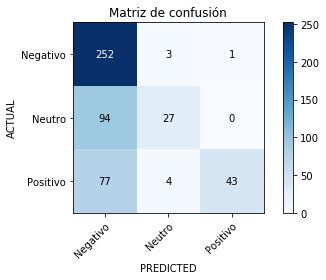

In [10]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

# Armo BOW
vectorizer = TfidfVectorizer(binary=False, ngram_range=(1, 2), norm= 'l2', smooth_idf= False, use_idf= True)
Xnum = vectorizer.fit_transform(X)
            
# Seteamos clasificador
clf = SVC(kernel='linear', C=1, gamma=0.001)

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

# prec = cross_val_score(clf, Xnum, y, cv=10, scoring='precision_macro')
# reca = cross_val_score(clf, Xnum, y, cv=10, scoring='recall_macro')
# print("Precision: %0.2f (+/- %0.2f)" % (prec.mean(), prec.std()))
# print("Recall:    %0.2f (+/- %0.2f)" % (reca.mean(), reca.std()))

print("\nHyper-parametros para generar BOW: \n\tbinary: \tFalse \n\tngram_range: \t(1, 2) \n\tnorm: \t\tl2 \n\tsmooth_idf: \tFalse \n\tuse_idf: \tTrue}")
print("\nHyper-parametros para clasificador: \n\tC: \t\t1 \n\tgamma: \t\t0.001 \n\tkernel: \tlinear")

class_names = ["Positivo","Neutro","Negativo"]

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred = cross_val_predict(clf, Xnum, y, cv=10)

#conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, title='Matriz de confusión')
plt.show()

#### Medidas de resumen SVM

In [18]:
import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{'negativo': 423, 'neutro': 34, 'positivo': 44}

### Resultados sobre Red Neuronal

Precision: 0.68 (+/- 0.09)
Recall:    0.59 (+/- 0.09)

Hyper-parametros para generar BOW: 
	alpha: 			0.01 
	hidden_layer_sizes: 	5 
	max_iter: 		300 
	solver: 		lbfgs

Hyper-parametros para clasificador: 
	binary: 	True 
	ngram_range: 	(1, 2) 
	norm: 		None 
	smooth_idf: 	False 
	use_idf: 	True


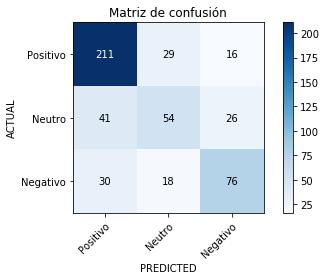

In [12]:
# Armo BOW
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2), norm= None, smooth_idf= False, use_idf= True)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = MLPClassifier(alpha= 0.01, hidden_layer_sizes= 8, max_iter= 300, solver= 'lbfgs')

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

print("\nHyper-parametros para generar BOW: \n\talpha: \t\t\t0.01 \n\thidden_layer_sizes: \t5 \n\tmax_iter: \t\t300 \n\tsolver: \t\tlbfgs")
print("\nHyper-parametros para clasificador: \n\tbinary: \tTrue \n\tngram_range: \t(1, 2) \n\tnorm: \t\tNone \n\tsmooth_idf: \tFalse \n\tuse_idf: \tTrue")


# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred = cross_val_predict(clf, Xnum, y, cv=10)

#conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, title='Matriz de confusión')
plt.show()

### Resultados sobre Naive Bayes

Precision: 0.68 (+/- 0.09)
Recall:    0.67 (+/- 0.08)

Hyper-parametros para generar BOW: 
	binary: 	False 
	ngram_range: 	(1, 1) 
	norm: 		l1 
	smooth_idf: 	False 
	use_idf: 	True

Hyper-parametros para clasificador: 
	alpha: 		0.5 
	fit_prior: 	False


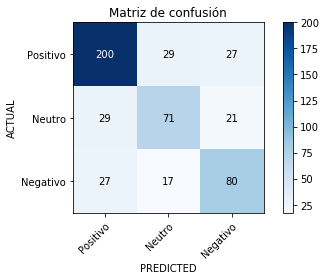

In [110]:
# Armo BOW
vectorizer = TfidfVectorizer(binary=False, ngram_range=(1, 1), norm= 'l1', smooth_idf= False, use_idf= True)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = MultinomialNB(alpha= 0.5, fit_prior= False)

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10, n_jobs=-1)
#print(scores['test_precision_macro'])
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

print("\nHyper-parametros para generar BOW: \n\tbinary: \tFalse \n\tngram_range: \t(1, 1) \n\tnorm: \t\tl1 \n\tsmooth_idf: \tFalse \n\tuse_idf: \tTrue")
print("\nHyper-parametros para clasificador: \n\talpha: \t\t0.5 \n\tfit_prior: \tFalse")


# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred = cross_val_predict(clf, Xnum, y, cv=10)

#conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, title='Matriz de confusión')
plt.show()

### Resultados sobre Arbol de Decision

Precision: 0.68 (+/- 0.10)
Recall:    0.49 (+/- 0.10)

Hyper-parametros para generar BOW: 
	binary: 	False 
	ngram_range: 	(1, 2) 
	norm: 		l1 
	smooth_idf: 	True 
	use_idf: 	False

Hyper-parametros para clasificador: 
	criterion: entropy 
	max_depth: 		12 
	min_samples_leaf: 	10


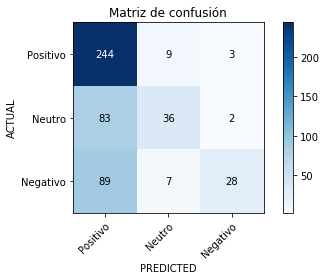

In [119]:
# Armo BOW
vectorizer = TfidfVectorizer(binary= False, ngram_range=(1, 2), norm= 'l1', smooth_idf= True, use_idf= False)
Xnum = vectorizer.fit_transform(X)

# Seteamos clasificador
clf = DecisionTreeClassifier(criterion= 'entropy', max_depth= 12, min_samples_leaf= 10)

scoring = ['precision_macro', 'recall_macro']
scores = cross_validate(clf, Xnum, y, scoring=scoring, cv=10, n_jobs=-1)

print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()))
print("Recall:    %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()))

print("\nHyper-parametros para generar BOW: \n\tbinary: \tFalse \n\tngram_range: \t(1, 2) \n\tnorm: \t\tl1 \n\tsmooth_idf: \tTrue \n\tuse_idf: \tFalse")
print("\nHyper-parametros para clasificador: \n\tcriterion: entropy \n\tmax_depth: \t\t12 \n\tmin_samples_leaf: \t10")

# Imprimir matriz de confusion.
clf = clf.fit(Xnum, y)
y_pred = cross_val_predict(clf, Xnum, y, cv=10)

#conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, title='Matriz de confusión')
plt.show()